## 1. Введение

Данные представлены в формате CSV.  Каждая строка представляет молекулу. 

Первый столбец Activity содержит экспериментальные данные, описывающие фактический биологический ответ [0, 1]; 
Остальные столбцы D1-D1776 представляют собой молекулярные дескрипторы — это вычисляемые свойства, которые могут фиксировать некоторые характеристики молекулы, например размер, форму или состав элементов.

Предварительная обработка не требуется, данные уже закодированы и нормализованы.

В качестве метрики будем использовать F1-score.

Необходимо обучить две модели: логистическую регрессию и случайный лес. Далее нужно сделать подбор гиперпараметров с помощью базовых и продвинутых методов оптимизации. Важно использовать все четыре метода (GridSeachCV, RandomizedSearchCV, Hyperopt, Optuna) хотя бы по разу, максимальное количество итераций не должно превышать 50.

## 2. Базовая оптимизация

In [1]:
#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные моделиё
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки

from sklearn.model_selection import cross_val_score
import hyperopt
from hyperopt import hp, fmin, tpe, Trials
# fmin - основная функция, она будет минимизировать наш функционал
# tpe - алгоритм оптимизации
# hp - включает набор методов для объявления пространства поиска гиперпараметров
# trails - используется для логирования результатов

import optuna

%matplotlib inline
plt.style.use('seaborn')

### Знакомство с данными и их исследование

In [2]:
data = pd.read_csv('_train_sem09 (1).csv')
data.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


Проверяем наличие пропусков

In [3]:
data.isnull().sum().max()

0

In [4]:
data.describe()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
count,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,...,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000
mean,0.542255,0.076948,0.592436,0.068142,0.038990,0.212112,0.686653,0.274713,0.455133,0.749517,...,0.026926,0.014663,0.013863,0.021861,0.015196,0.016796,0.012263,0.011730,0.020261,0.011197
std,0.498278,0.079989,0.105860,0.078414,0.115885,0.102592,0.078702,0.090017,0.162731,0.071702,...,0.161889,0.120215,0.116938,0.146249,0.122348,0.128522,0.110074,0.107683,0.140911,0.105236
min,0.000000,0.000000,0.282128,0.000000,0.000000,0.002630,0.137873,0.006130,0.000000,0.275590,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.033300,0.517811,0.000000,0.000000,0.138118,0.625627,0.207374,0.378062,0.707339,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.066700,0.585989,0.050000,0.000000,0.190926,0.674037,0.277845,0.499942,0.738961,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.100000,0.668395,0.100000,0.000000,0.261726,0.740663,0.335816,0.569962,0.788177,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,0.964381,0.950000,1.000000,1.000000,0.994735,0.790831,0.989870,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Смотрим на сбалансированность классов:

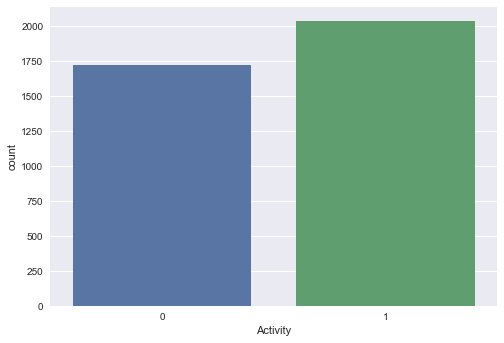

In [5]:
sns.countplot(data=data, x='Activity');

Видим, что классы хоть и не сбалансированя, но близки к этому.

Создаем матрицу наблюдений $X$ и вектор ответов $y$

In [6]:
X = data.drop(['Activity'], axis=1)
y = data['Activity']

Разделяем выборку на тренировочную и тестовую в соотношении 80/20. Для сохранения соотношений целевого признака используем параметр stratify (стратифицированное разбиение). 

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.2)

### Оптимизация гиперпараметров модели

# <center> **Логистическая регрессия**

Зафиксируем только метрики, которые были получены без дополнительной настройки, т.е со значениями гиперпараметров, установленных по умолчанию:

In [8]:
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(random_state=42, max_iter = 1000)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train, y_train)
print("accuracy на тестовом наборе: {:.2f}".format(log_reg.score(X_test, y_test)))
y_test_pred = log_reg.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.75
f1_score на тестовом наборе: 0.78


### <center> **GridSearchCV**

In [9]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'solver': ['saga'], # алгоритм оптимизации
     'penalty': ['l1', 'l2'], # тип регуляризации
     'C': list(np.linspace(0.01, 1, 10, dtype=float)) # уровень силы регурялизации 
    },
        
    {'solver': ['lbfgs'],
     'penalty': ['l2'],
     'C': list(np.linspace(0.01, 1, 10, dtype=float))
    }
]

grid_search = GridSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=1000), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  


%time grid_search.fit(X_train, y_train) 
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

y_test_pred = grid_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))


Wall time: 21min 56s
Наилучшие значения гиперпараметров: {'C': 0.23, 'penalty': 'l1', 'solver': 'saga'}
f1_score на тестовом наборе: 0.78


c:\Users\mish9\.conda\envs\sf\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


### <center> **RandomizedSearchCV**

In [10]:
from sklearn.model_selection import RandomizedSearchCV

param_distributions = [
    {'solver': ['saga'], # алгоритм оптимизации
     'penalty': ['l1', 'l2'], # тип регуляризации
     'C': list(np.linspace(0.01, 1, 10, dtype=float)) # уровень силы регурялизации 
    },
        
    {'solver': ['lbfgs'],
     'penalty': ['l2'],
     'C': list(np.linspace(0.01, 1, 10, dtype=float))
    }
]

random_search = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=1000), 
    param_distributions=param_distributions, 
    cv=5, 
    n_iter = 10, 
    n_jobs = -1
)  

%time random_search.fit(X_train, y_train) 
print("Наилучшие значения гиперпараметров: {}".format(random_search.best_params_))

y_test_pred = random_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Wall time: 8min 7s
Наилучшие значения гиперпараметров: {'solver': 'saga', 'penalty': 'l1', 'C': 0.45}
f1_score на тестовом наборе: 0.78


c:\Users\mish9\.conda\envs\sf\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


### <center> **Hyperopt**

In [11]:
# Параметр регуляризации выбирается случайным образом из равномерного распределения
space = hp.choice('parameter_combinations', [
        {'solver': 'saga',
         'penalty': hp.choice('penalty', ['l1', 'l2']),
         'C': hp.uniform('C_saga', 0.01, 1)
        },
        
        {'solver': 'lbfgs',
        'penalty': 'l2',
        'C': hp.uniform('C_lbfgs', 0.01, 1)
        }
        ]
)

# Целевая функция
def obj_func(params, cv=5, X=X_train, y=y_train, random_state=42):
    params = {'solver': params['solver'], 
              'penalty': params['penalty'], 
              'C': params['C']
             }
      
    model = linear_model.LogisticRegression(**params, class_weight='balanced', 
        random_state=random_state, max_iter=1000
    )
      
    # Обучаем модель с помощью кросс-валидации
    score = cross_val_score(model, X, y, cv=cv, scoring='f1', n_jobs=-1).mean()

    return -score 


trials = Trials()
best=fmin(obj_func, 
          space=space, 
          algo=tpe.suggest, 
          max_evals=20, 
          trials=trials, 
          #rstate=np.random.RandomState(random_state)
          rstate=np.random.default_rng(42)
         )
print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████| 20/20 [14:08<00:00, 42.42s/trial, best loss: -0.7801633308319003]
Наилучшие значения гиперпараметров {'C_saga': 0.10567819922023905, 'parameter_combinations': 0, 'penalty': 1}


In [12]:
# рассчитаем точность для тестовой выборки
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(
    random_state=42, 
    max_iter = 1000,
    penalty = 'l2',
    solver = 'saga',
    C = 0.11, 
    )
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train, y_train)
y_test_pred = log_reg.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.79


### <center> **Optuna**

In [13]:
# Целевая функция
def obj_func(trial):
    # пространство гиперпараметров
    solver = trial.suggest_categorical('solver', ['saga', 'lbfgs'])
    if solver == 'saga':
        penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    else:
        penalty = 'l2'
    C = trial.suggest_uniform('C', 0.01, 1)
    
    model = linear_model.LogisticRegression(
        solver=solver,
        penalty=penalty,
        C=C,
        class_weight='balanced', 
        random_state=42, 
        max_iter=1000
    )    
    
    # Обучаем модель с помощью кросс-валидации    
    score = cross_val_score(
        model, X_train, y_train, cv=5, scoring='f1', n_jobs=-1).mean()
    
    return score


# Поиск оптимальных гиперпараметров
sampler = optuna.samplers.TPESampler(seed=42)
study_lr = optuna.create_study(
    sampler=sampler, study_name='LogisticRegression', direction='maximize')
study_lr.optimize(obj_func, n_trials=20)


# Модель с лучшими параметрами
optuna_lr = linear_model.LogisticRegression(
    **study_lr.best_params, class_weight='balanced', n_jobs=-1,
    random_state=42, max_iter=1000
)
optuna_lr.fit(X_train, y_train)
print(f'Наилучшие значения гиперпараметров: {study_lr.best_params}')

y_test_pred = optuna_lr.predict(X_test)
print(f'F1 на тестовой выборке: {metrics.f1_score(y_test, y_test_pred)}')

[I 2023-01-12 21:52:02,871] A new study created in memory with name: LogisticRegression
C:\Users\mish9\AppData\Local\Temp/ipykernel_6684/3826843513.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_uniform('C', 0.01, 1)
[I 2023-01-12 21:52:12,232] Trial 0 finished with value: 0.768874024532912 and parameters: {'solver': 'lbfgs', 'C': 0.7346740023932911}. Best is trial 0 with value: 0.768874024532912.
C:\Users\mish9\AppData\Local\Temp/ipykernel_6684/3826843513.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_uniform('C', 0.01, 1)
[I 2023-01-12 21:54:53,652] Trial 1 finished with value: 0.7778942370356219 and pa

Наилучшие значения гиперпараметров: {'solver': 'saga', 'penalty': 'l1', 'C': 0.2728170123162879}
F1 на тестовой выборке: 0.773561811505508


c:\Users\mish9\.conda\envs\sf\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


# В итоге для Логистической регрессии мы получили следующие метрики:
* GridSearchCV **f1 = 0.78** {'C': 0.23, 'penalty': 'l1', 'solver': 'saga'}
* RandomizedSearchCV **f1 = 0.78** {'C': 0.34, 'penalty': 'l1', 'solver': 'saga'} 
* Hyperopt **f1 = 0.79** {'C': 0.11, 'penalty': 'l2', 'solver': 'saga'}
* Optuna **f1 = 0.77** {'C': 0.27, 'penalty': 'l1', 'solver': 'saga'}

Лучшим методом оптимизации является: Hyperopt **f1 = 0.79** {'C': 0.1057, 'penalty': 'l2', 'solver': 'saga'}

# <center> **Случайный лес**

Проделаем аналогичное для RandomForestClassifier().
Сначала посчитаем модель с параметрами по умолчанию и оценим метрику:

In [14]:
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(random_state=42)

#Обучаем модель
rf.fit(X_train, y_train)
#Выводим значения метрики 
y_train_pred = rf.predict(X_train)
print('f1_score на тренировочном наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = rf.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тренировочном наборе: 1.00
f1_score на тестовом наборе: 0.80


### <center> **GridSearchCV**

In [15]:
param_grid = {
    'n_estimators': list(range(80, 200, 30)), # количество деревьев в лесу
    'min_samples_leaf': [5, 10], # минимальное количество объектов в листе
    'max_depth': list(np.linspace(20, 40, 5, dtype=int)) # максимальная глубина дерева
}
            
grid_search_forest = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_forest.fit(X_train, y_train) 
print("Наилучшие значения гиперпараметров: {}".format(grid_search_forest.best_params_))

y_test_pred = grid_search_forest.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Wall time: 1min 38s
Наилучшие значения гиперпараметров: {'max_depth': 20, 'min_samples_leaf': 5, 'n_estimators': 140}
f1_score на тестовом наборе: 0.80


### <center> **RandomizedSearchCV**

In [16]:
param_distributions = {
    'n_estimators': list(range(80, 200, 30)), # количество деревьев в лесу
    'min_samples_leaf': [5, 10], # минимальное количество объектов в листе
    'max_depth': list(np.linspace(20, 40, 5, dtype=int)) # максимальная глубина дерева
}
            
random_search_forest = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_distributions=param_distributions, 
    cv=5,
    n_iter = 10, 
    n_jobs = -1
)  
%time random_search_forest.fit(X_train, y_train) 
print("Наилучшие значения гиперпараметров: {}".format(random_search_forest.best_params_))

y_test_pred = random_search_forest.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Wall time: 27.5 s
Наилучшие значения гиперпараметров: {'n_estimators': 140, 'min_samples_leaf': 5, 'max_depth': 20}
f1_score на тестовом наборе: 0.80


### <center> **Hyperopt**

In [17]:
# Пространство параметров: создаем несколько словарей с наборами параметров, 
# т.к. L-BFGS оптимизатор не работает c L1-регуляризацией.
#
# Параметр регуляризации выбирается случайным образом из равномерного распределения
space={'n_estimators': hp.quniform('n_estimators', 80, 200, 30), # количество деревьев в лесу
       'min_samples_leaf': hp.quniform('min_samples_leaf', 5, 10, 1), # минимальное количество объектов в листе
       'max_depth' : hp.choice('max_depth', [20, 25, 30, 35, 40]) # максимальная глубина дерева      
      }


# Целевая функция
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=42):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])
              }
  
    # используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier(**params, random_state=42)

    # обучаем модель
    model.fit(X, y)
    score = metrics.f1_score(y, model.predict(X))
    
    # обучать модель можно также с помощью кросс-валидации
    # применим  cross validation с тем же количеством фолдов
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score


trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=40, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(42)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████| 40/40 [04:54<00:00,  7.36s/trial, best loss: -0.8124398182784629]
Наилучшие значения гиперпараметров {'max_depth': 3, 'min_samples_leaf': 6.0, 'n_estimators': 210.0}


In [18]:
# рассчитаем точность для тестовой выборки
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(
    random_state=42,
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
    )

#Обучаем модель
rf.fit(X_train, y_train)
#Выводим значения метрики 
y_train_pred = rf.predict(X_train)
print('f1_score на тренировочном наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = rf.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тренировочном наборе: 0.77
f1_score на тестовом наборе: 0.74


### <center> **Optuna**

In [19]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 80, 200, 30)
  max_depth = trial.suggest_int('max_depth', 20, 40, 5)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 5, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  # обучаем модель
  model.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train))

  return score

# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=40)

# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

[I 2023-01-12 22:29:56,536] A new study created in memory with name: RandomForestClassifier
[I 2023-01-12 22:29:59,256] Trial 0 finished with value: 0.9287020109689215 and parameters: {'n_estimators': 170, 'max_depth': 20, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.9287020109689215.
[I 2023-01-12 22:30:01,655] Trial 1 finished with value: 0.8961948249619481 and parameters: {'n_estimators': 170, 'max_depth': 20, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.9287020109689215.
[I 2023-01-12 22:30:03,587] Trial 2 finished with value: 0.9423604757548033 and parameters: {'n_estimators': 110, 'max_depth': 30, 'min_samples_leaf': 5}. Best is trial 2 with value: 0.9423604757548033.
[I 2023-01-12 22:30:04,992] Trial 3 finished with value: 0.9410326917201345 and parameters: {'n_estimators': 80, 'max_depth': 40, 'min_samples_leaf': 5}. Best is trial 2 with value: 0.9423604757548033.
[I 2023-01-12 22:30:07,095] Trial 4 finished with value: 0.9115853658536586 and parameters: {'n_

Наилучшие значения гиперпараметров {'n_estimators': 200, 'max_depth': 25, 'min_samples_leaf': 5}
f1_score на обучающем наборе: 0.95


In [20]:
# рассчитаем точность для тестовой выборки
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(
    random_state=42,
    n_estimators=int(study.best_params['n_estimators']),
    max_depth=int(study.best_params['max_depth']),
    min_samples_leaf=int(study.best_params['min_samples_leaf'])
    )

#Обучаем модель
rf.fit(X_train, y_train)
#Выводим значения метрики 
y_train_pred = rf.predict(X_train)
print('f1_score на тренировочном наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = rf.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тренировочном наборе: 0.95
f1_score на тестовом наборе: 0.80


# В итоге для случайного леса мы получили следующие метрики:
* GridSearchCV **f1 = 0.8** {'max_depth': 20, 'min_samples_leaf': 5, 'n_estimators': 140}
* RandomizedSearchCV **f1 = 0.81** {'max_depth': 35, 'min_samples_leaf': 5, 'n_estimators': 170}
* Hyperopt **f1 = 0.74** {'max_depth': 3, 'min_samples_leaf': 6.0, 'n_estimators': 210.0}
* Optuna **f1 = 0.8** {'max_depth': 25, 'min_samples_leaf': 5,  'n_estimators': 200}

Лучшим методом оптимизации является: RandomizedSearchCV **f1 = 0.81** {'max_depth': 35, 'min_samples_leaf': 5, 'n_estimators': 170}. Он же показал лучшие результаты, по сравнению с оптимизациями логистической регрессии.